# MSc in Artificial Intelligence - Deep Learning

## Authors:  Carlis Vasileios, Toliopoulou Christina-Anna

This project is part of second semester Deep Learning course hosted at NCSR Demokritos and University of Pireaus

# Introduction

In this project, we deal with the problem of classifying images of clothes. The data are retrieved from Tensorflow API. Fashion MNIST dataset contains 70,000 grayscale images belonging to 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:


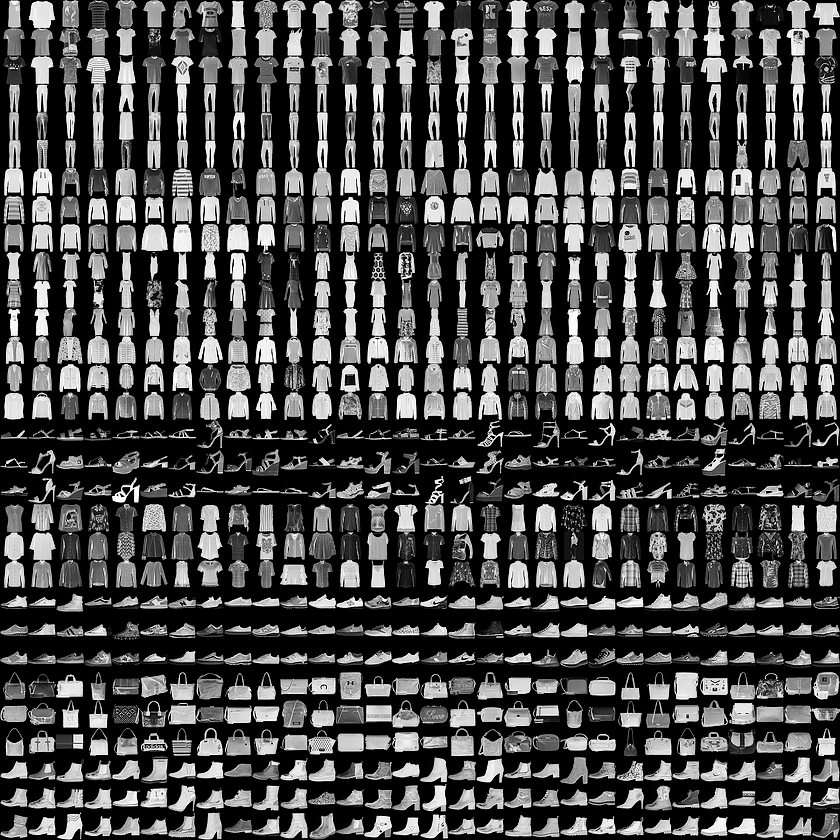



# Libraries used



In [18]:
for name in dir():
    if not name.startswith('_'):
        del globals()[name]



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.random import set_seed
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
import itertools
import gc
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')


# Data exploration

Data are retrieved from Keras library. Loading the dataset returns four NumPy arrays:

- The train_images and train_labels arrays are the training set the data the model uses to learn.
- The model is tested against the test set, the test_images, and test_labels arrays.
- The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. 
- The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing 


---
0	T-shirt/top
<br>
1	Trouser
<br>
2	Pullover
<br>
3	Dress
<br>
4	Coat
<br>
5	Sandal
<br>
6	Shirt
<br>
7	Sneaker
<br>
8	Bag
<br>
9	Ankle boot

We firstly explored our data and exported some plots which would help us have a first glance on the problem. The definition of our y labels is also stated here.





Shape of data: (60000, 28, 28)
Unique Values of target labels :  [0 1 2 3 4 5 6 7 8 9]


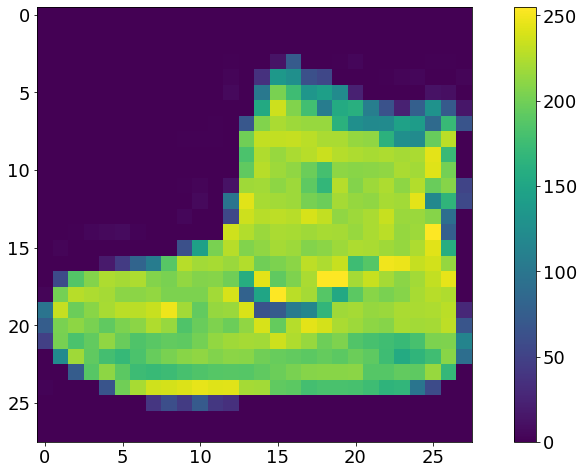

In [19]:
#load dataset (fashion mnist)
mydataset = keras.datasets.fashion_mnist
(x_train_images, y_train_labels), (x_test_images, y_test_labels) = mydataset.load_data()

#observe shape of data
print('Shape of data:' , x_train_images.shape)

#observe y labels

uniqueValues, indicesList = np.unique(y_train_labels, return_index=True)

print('Unique Values of target labels : ', uniqueValues)

#see initial plots 

plt.figure()
plt.imshow(x_train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

#define class names ( types of clothes-shoes )

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



# Data Transformation

In order to train a NN we need to scale the pixels of our images to 0,1. Also here we are spliting our train set in final train and validation, for modeling phase

In [20]:
#split the initial train set in final train set and validation set
x_train_images, x_valid_images, y_train_labels, y_valid_labels = train_test_split(x_train_images, y_train_labels, test_size=0.1)


#scaling train_images, valid_images and test_images (rgb values 0 -255,, x_train_images, x_valid_images, x_test_images between 0 and 1)
x_train_images = x_train_images / 255.0
x_valid_images = x_valid_images / 255.0
x_test_images = x_test_images / 255.0


# Train- Validation -Test size

print('Size of validation set', len(x_valid_images))
print('Size of train set',len(x_train_images))
print('Size of test set',len(x_test_images))






Size of validation set 6000
Size of train set 54000
Size of test set 10000


## Show some plots after scaling




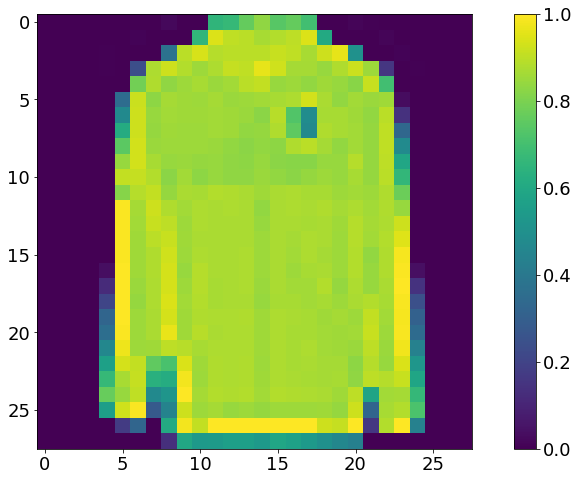

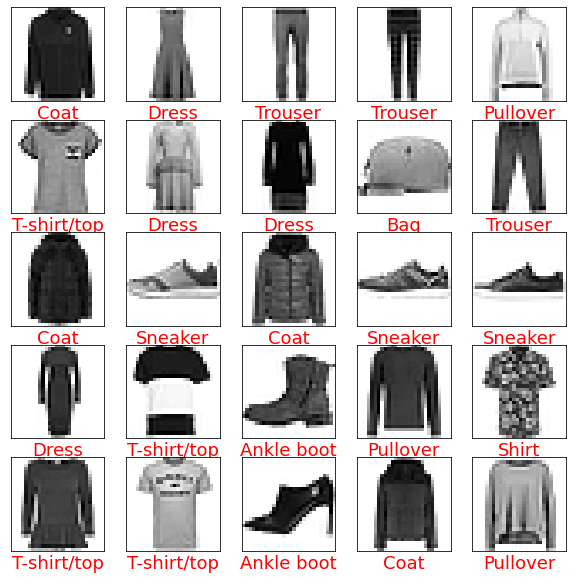

In [21]:

#plots after scaling
plt.figure()
plt.imshow(x_train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train_labels[i]],color='red')
plt.show()


# Data Transformation - continued

In [22]:
#one hot level encoding for our labels

y_train_labels = tf.keras.utils.to_categorical(y_train_labels, 10, dtype='uint8')
y_valid_labels = tf.keras.utils.to_categorical(y_valid_labels, 10, dtype='uint8')
y_test_labels = tf.keras.utils.to_categorical(y_test_labels, 10, dtype='uint8')

print(y_train_labels)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]


# Functions used in modeling

Here we create all the functions that will be used later on the modeling phase

At the first layer of the network, we use flatten in order to tranform the dimensions of images from 2d to one vector.

In [6]:
#function for plotting train accuracy and validation accuracy
def plot_accuracy(myhistory, epochs, y_low, y_high,loss_function):
    print()
    #define parameters of figure
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 18
    plt.clf()
    #loop in values
    for label in myhistory:
        #plot train accuracy
        plt.plot(myhistory[label].history['accuracy'], label='{0:s} Train Accuracy'.format(label))
        #plot test accuracy 
        plt.plot(myhistory[label].history['val_accuracy'], label='{0:s} Validation Accuracy'.format(label))
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    #change epoch
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((y_low, y_high))
    plt.xlabel('Epochs')
    plt.ylabel(loss_function)
    plt.legend()
    plt.show()
    
    



#function for plotting train loss and validation loss
def plot_loss(myhistory, epochs, y_low, y_high,loss_function):
    print()
    #define parameters of figure
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 18
    plt.clf()
    #loop in values
    for label in myhistory:
      #plot train loss
        plt.plot(myhistory[label].history['loss'], label='{0:s} Train Loss'.format(label))
        #ploat validation loss
        plt.plot(myhistory[label].history['val_loss'], label='{0:s} Validation Loss'.format(label))
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((y_low, y_high))
    plt.xlabel('Epochs')
    plt.ylabel(loss_function)
    plt.legend()
    plt.show()

#clean previous model, in order to use the new
def clean_model(model):
    K.clear_session()
    #delete model
    del model
    gc.collect()


#creation of model, with the appropriate parameters
def create_model(
    optimizer,
    loss_function,
    vector_size,
    hidden_layers=0,
    hidden_activation='relu',
    output_activation='softmax'
):
    #define dimensions
    dimensions = x_train_images[0].shape
    #seed for randomness
    np.random.seed(1402)
    set_seed(1981) 

    # Create sequential model
    mymodel = Sequential()
    mymodel.add(Flatten(input_shape = dimensions))
    # #Create Hidden Layers 
    for i in range(hidden_layers):
        counter = i + 1
        mymodel.add(Dense(vector_size / counter, activation=hidden_activation, kernel_initializer = 'glorot_uniform' ,input_shape=(dimensions[0]*dimensions[1],)))
    #output layer
    mymodel.add(Dense(10, activation=output_activation,kernel_initializer = 'glorot_uniform')) 


    # Compile the model
    mymodel.compile(optimizer=optimizer, loss=loss_function,metrics=['accuracy'])
    return mymodel


#train of model
def train_model(
    model,
    train_data,
    train_labels,
    validation_data,
    epochs=5000,
    batch_size=1024
):
  #use model.fit to train the model. The most important inouts are: the train_data and the train_labels 
    x = model.fit(
        x=train_data,
        y=train_labels,
        validation_data=validation_data,
        epochs=epochs,
        verbose=0,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    return x


    
def train_model_es(
    model,
    train_data,
    train_labels,
    validation_data,
    epochs=6000,
    batch_size=1024
):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
   
    # This callback will stop the training when there is no improvement in
    # the validation loss for three consecutive epochs.

    hs = model.fit(
        x=train_data,
        y=train_labels,
        validation_data=validation_data,
        callbacks=[callback],
        epochs=epochs,
        verbose=1,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    return hs


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




# Model 1 - Logistic Regression

Here we train a simple logistic regression model withou any hidden layer. At the first layer of the network, we use flatten in order to tranform the dimensions of images from 2d to one vector.The achieved results are decent, but this has to do with the nature of our problem

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Finished training.
------------------
313/313 [==============================] - 0s 564us/step - loss: 0.5129 - accuracy: 0.8260
Result of Train Loss     : 0.48286
Result of Validation Loss: 0.49191
Result of Test Loss      : 0.51294
Result of Train accuracy     : 0.83911
Result of Validation accuracy: 0.83683
Result of Test accuracy      : 0.82600



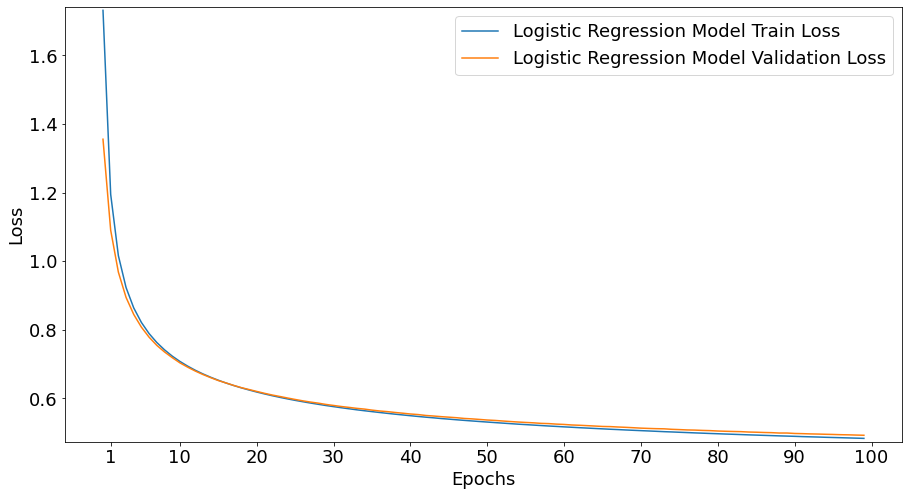

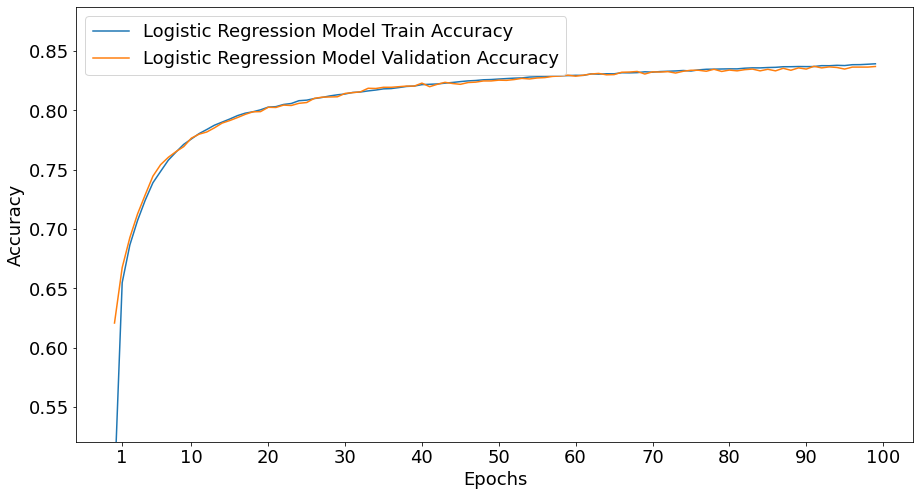

In [7]:
#use sgd optimizer

#define learning rate=0.1

optimizer = SGD(lr=0.01)
epochs = 100

# Logistic Regression

#create model
lr_model = create_model(
    optimizer=optimizer,
    #define categorical_crossentropy as loss function (because it is a multiclass classification problem)
    loss_function='categorical_crossentropy',
    vector_size=10,
    hidden_layers=0,
    hidden_activation='relu',
    output_activation='softmax'
)
lr_model.summary() # Print a description of the model.

#train_model
lr_model_history = train_model(
    model=lr_model,
    train_data=x_train_images,
    train_labels=y_train_labels,
    validation_data=(x_valid_images, y_valid_labels),
    epochs=epochs,
    batch_size=540 # x_train_images.shape[0], batch size: the number of training examples in one forward/backward pass. 54000 samples.

)
#evaluate the model
lr_model_evaluation = lr_model.evaluate(x_test_images, y_test_labels, verbose=1)
clean_model(model=lr_model)

#print results for loss(train, validation and test)
print("Result of Train Loss     : {0:.5f}".format(lr_model_history.history['loss'][-1]))
print("Result of Validation Loss: {0:.5f}".format(lr_model_history.history['val_loss'][-1]))
print("Result of Test Loss      : {0:.5f}".format(lr_model_evaluation[0]))

#print results for accuracy (train, validation and test )
print("Result of Train accuracy     : {0:.5f}".format(lr_model_history.history['accuracy'][-1]))
print("Result of Validation accuracy: {0:.5f}".format(lr_model_history.history['val_accuracy'][-1]))
print("Result of Test accuracy      : {0:.5f}".format(lr_model_evaluation[1]))


#print loss per epoch
plot = plot_loss(myhistory={'Logistic Regression Model': lr_model_history}, epochs=epochs, y_low = min(lr_model_history.history['loss']) - 0.01, y_high=max(lr_model_history.history['loss'])+0.01,loss_function = 'Loss')

#plot accuracy per epoch
plot = plot_accuracy(myhistory={'Logistic Regression Model': lr_model_history}, epochs=epochs, y_low= min(lr_model_history.history['val_accuracy']) - 0.1, y_high=max(lr_model_history.history['val_accuracy']) + 0.05,loss_function = 'Accuracy')


# Model 2 - MLP NN v1

- Creation and testing of a simple MLP network:

- Characteristics of the network:

- 1 hidden layer ( 10 nodes )

- 1 output layer (10 nodes)

- Activation function: relu 

- Loss function -> categorical crossentropy

- optimizer :SGD

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
Finished training.
------------------
313/313 [==============================] - 0s 571us/step - loss: 0.4321 - accuracy: 0.8487
Result of Train Loss     : 0.37579
Result of Validation Loss: 0.42431
Result of Test Loss      : 0.43207
Result of Train accuracy     : 0.86959
Result of Validation accuracy: 0.84917
Result of Test accuracy      : 0.84870



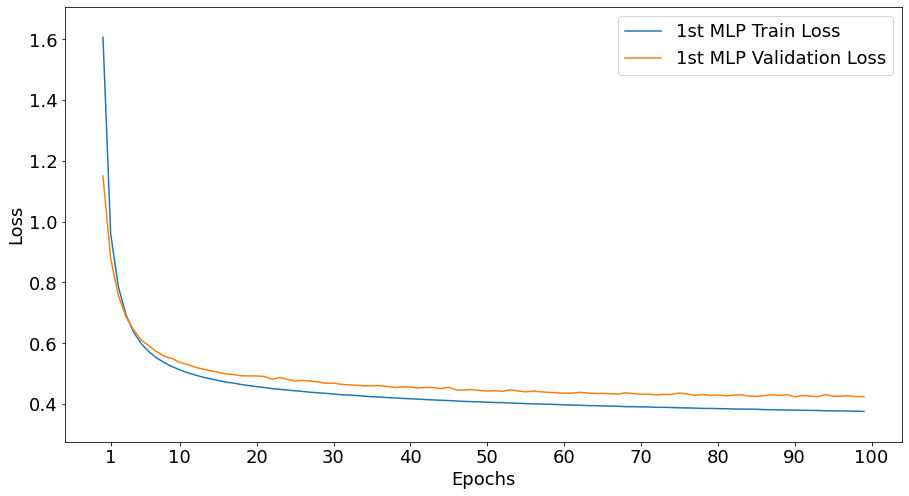

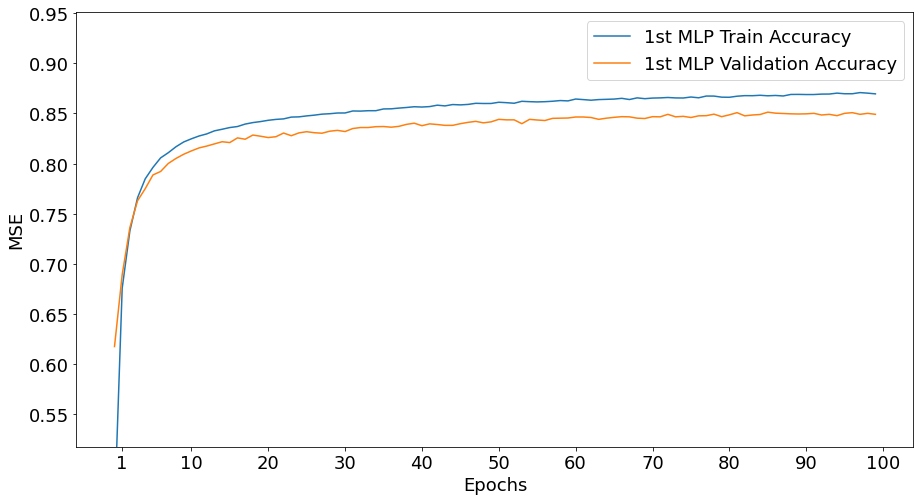

In [9]:
#define optimizer (learning rate = 0.01)
optimizer = SGD(lr=0.01)

#define epochs
epochs = 100

#creation of model
relu_model_v1 = create_model(
    optimizer=optimizer,
    #categorical_crossentropy (multiclass problem)
    loss_function='categorical_crossentropy',
    vector_size=10,
    #define number of hidden layers 
    hidden_layers=1,
    hidden_activation='relu',
    output_activation='softmax'
)

#print model details
relu_model_v1.summary() 

#train model
relu_model_history_v1 = train_model(
    model=relu_model_v1,
    train_data=x_train_images,
    train_labels=y_train_labels,
    validation_data=(x_valid_images, y_valid_labels),
    epochs=epochs,
    batch_size = 128 # x_train_images.shape[0], batch size: the number of training examples in one forward/backward pass. 54000 samples.
)
#evaluate the training process
relu_model_evaluation_v1 = relu_model_v1.evaluate(x_test_images, y_test_labels, verbose=1)

#clean the model
clean_model(model=relu_model_v1)

#print results for loss(train, validation, test )
print("Result of Train Loss     : {0:.5f}".format(relu_model_history_v1.history['loss'][-1]))
print("Result of Validation Loss: {0:.5f}".format(relu_model_history_v1.history['val_loss'][-1]))
print("Result of Test Loss      : {0:.5f}".format(relu_model_evaluation_v1[0]))

#print results for accuracy(train, validation and test )
print("Result of Train accuracy     : {0:.5f}".format(relu_model_history_v1.history['accuracy'][-1]))
print("Result of Validation accuracy: {0:.5f}".format(relu_model_history_v1.history['val_accuracy'][-1]))
print("Result of Test accuracy      : {0:.5f}".format(relu_model_evaluation_v1[1]))

# Plot loss per epoch
plot = plot_loss(myhistory={'1st MLP': relu_model_history_v1}, epochs=epochs, y_low = min(relu_model_history_v1.history['loss']) - 0.1, y_high=max(relu_model_history_v1.history['loss'])+0.1,loss_function = 'Loss')

# Plot accuracy per epoch
plot = plot_accuracy(myhistory={'1st MLP': relu_model_history_v1}, epochs=epochs, y_low = min(relu_model_history_v1.history['val_accuracy']) - 0.1, y_high=max(relu_model_history_v1.history['val_accuracy']) + 0.1,loss_function = 'MSE')








# Model 3 - MLP NN v2

Creation and testing of a second MLP network:

Characteristics of the network:

- 2 hidden layers (first layer: 256 nodes, second layer: 128 nodes )

- 1 output layer(10 nodes)

- Activation function: relu 

- Loss function -> categorical crossentropy

- optimizer :SGD


As we can observe from the below  plots, while the epochs increase, the distance between train and validation loss is increased. This is a sign of overfitting which we will have to deal with using a dropout method. 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
Finished training.
------------------
313/313 [==============================] - 0s 868us/step - loss: 0.3345 - accuracy: 0.8841
Result of Train Loss: 0.22149
Result of Validation Loss: 0.33104
Result of Test Loss: 0.33453
Result of Train accuracy 

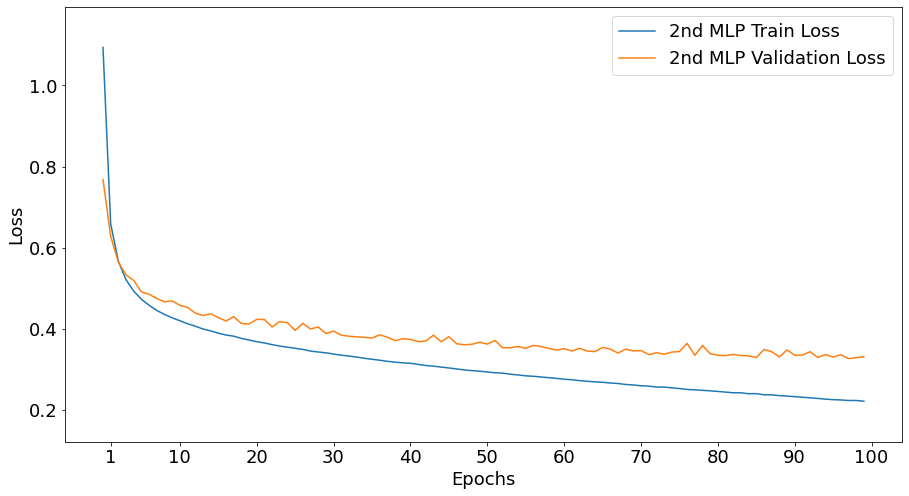

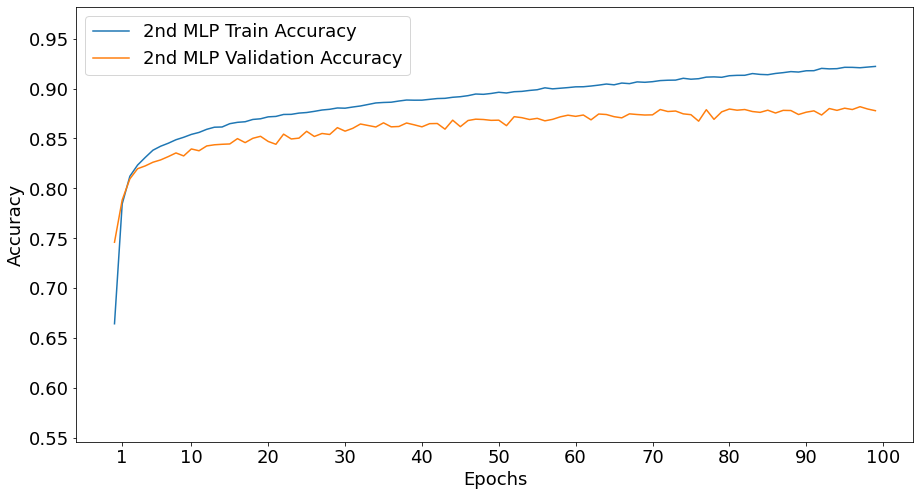

In [10]:
#define optimizer
optimizer = SGD(lr=0.01)

#define epochs
epochs = 100

#create model
relu_model_v2 = create_model(
    optimizer=optimizer,
    loss_function='categorical_crossentropy',
    vector_size=256,
    #define number of hidden layers 
    hidden_layers=2,
    hidden_activation='relu',
    output_activation='softmax'
)

#print details of model
relu_model_v2.summary()

#train model 
relu_model_history_v2 = train_model(
    model=relu_model_v2,
    train_data=x_train_images,
    train_labels=y_train_labels,
    validation_data=(x_valid_images, y_valid_labels),
    epochs=epochs,
    batch_size= 128# x_train_images.shape[0]
)

#evaluate of training process
relu_model_evaluation_v2 = relu_model_v2.evaluate(x_test_images, y_test_labels, verbose=1)

#clean model 
clean_model(model=relu_model_v2)

#print loss(train loss, vadlidation loss, and test loss)
print("Result of Train Loss: {0:.5f}".format(relu_model_history_v2.history['loss'][-1]))
print("Result of Validation Loss: {0:.5f}".format(relu_model_history_v2.history['val_loss'][-1]))
print("Result of Test Loss: {0:.5f}".format(relu_model_evaluation_v2[0]))

#print accuracy(train, validation, and test )
print("Result of Train accuracy     : {0:.5f}".format(relu_model_history_v2.history['accuracy'][-1]))
print("Result of Validation accuracy: {0:.5f}".format(relu_model_history_v2.history['val_accuracy'][-1]))
print("Result Test accuracy      : {0:.5f}".format(relu_model_evaluation_v2[1]))

# Plot loss per  epoch
plot = plot_loss(myhistory={'2nd MLP': relu_model_history_v2}, epochs=epochs, y_low = min(relu_model_history_v2.history['loss']) - 0.1, y_high=max(relu_model_history_v2.history['loss'])+0.1,loss_function = 'Loss')


# Plot accuracy per epoch
plot = plot_accuracy(myhistory={'2nd MLP': relu_model_history_v2}, epochs=epochs, y_low = min(relu_model_history_v2.history['val_accuracy']) - 0.2, y_high=max(relu_model_history_v2.history['val_accuracy']) + 0.1,loss_function = 'Accuracy')







# Dropout method

In order to avoid overfitting we apply the dropout method, when randomly selected neurons are ignored during training.

In [8]:
def create_model_dropout(
    optimizer,
    loss_function,
    vector_size,
    hidden_layers=0,
    hidden_activation='relu',
    output_activation='softmax',
    drop_out=0.4
):
    dimensions = x_train_images[0].shape
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.

    # Model
    model = Sequential()
    model.add(Flatten(input_shape = dimensions))
    # #Hidden Layers
    for i in range(hidden_layers):
        div = i + 1
        model.add(Dense(vector_size / div, activation=hidden_activation, kernel_initializer = 'glorot_uniform' ,input_shape=(dimensions[0]*dimensions[1],)))
        model.add(Dropout(drop_out))
    #Output Layer
    model.add(Dense(10, activation=output_activation,kernel_initializer = 'glorot_uniform')) 


    # Compile the model
    model.compile(optimizer=optimizer, loss=loss_function,metrics=['accuracy'])
    return model

# Model 3- MLP NN v3 with Dropout

In [9]:
# Using SGD
optimizer = SGD(lr=0.01)
epochs = 100

relu_model_dropout = create_model_dropout(
    optimizer=optimizer,
    loss_function='categorical_crossentropy',
    vector_size=256,
    hidden_layers=2,
    hidden_activation='relu',
    output_activation='softmax',
    drop_out=0.2
)
relu_model_dropout.summary() # Print a description of the model.

relu_model_history_dropout = train_model(
    model=relu_model_dropout,
    train_data=x_train_images,
    train_labels=y_train_labels,
    validation_data=(x_valid_images, y_valid_labels),
    epochs=epochs,
    batch_size= 128# x_train_images.shape[0]
)

relu_model_evaluation_dropout = relu_model_dropout.evaluate(x_test_images, y_test_labels, verbose=1)
clean_model(model=relu_model_dropout)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
__________________________________________________

It is clear that using the dropout method the learning rate becomes smoother but the distance of loss in train and validation datasets is close enough. This means that using dropout we avoid the overfitting of the model in training data. This can be seen below

Result of Train Loss: 0.26929
Result of Validation Loss: 0.30174
Result of Test Loss: 0.32145
Result of Train accuracy     : 0.90248
Result of Validation accuracy: 0.89167
Result Test accuracy      : 0.88310



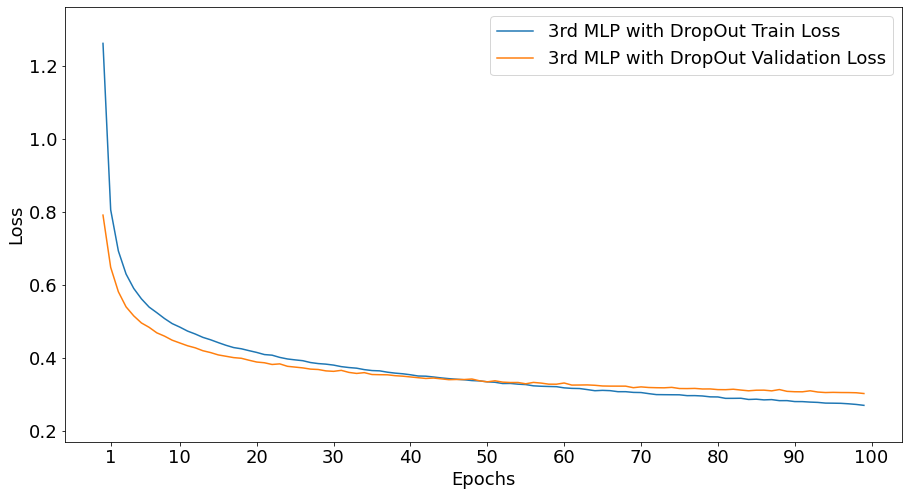

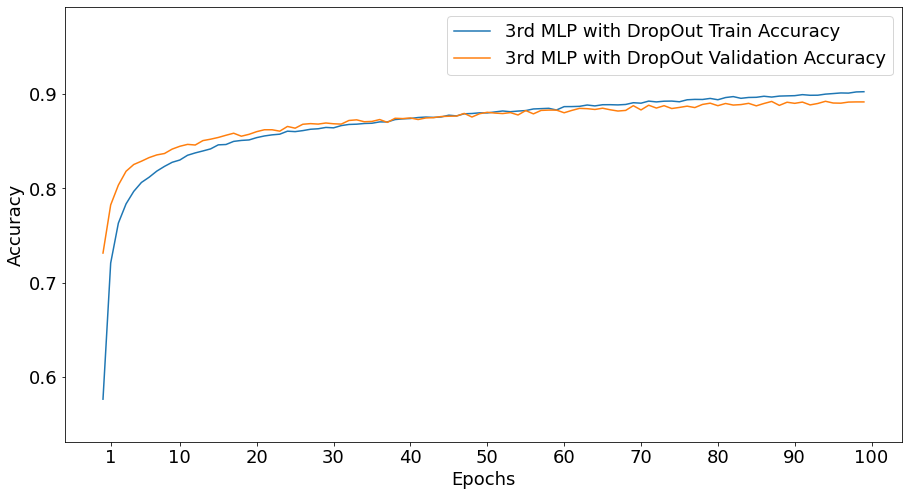

In [10]:
#print loss(train loss, vadlidation loss, and test loss)
print("Result of Train Loss: {0:.5f}".format(relu_model_history_dropout.history['loss'][-1]))
print("Result of Validation Loss: {0:.5f}".format(relu_model_history_dropout.history['val_loss'][-1]))
print("Result of Test Loss: {0:.5f}".format(relu_model_evaluation_dropout[0]))

#print accuracy(train, validation, and test )
print("Result of Train accuracy     : {0:.5f}".format(relu_model_history_dropout.history['accuracy'][-1]))
print("Result of Validation accuracy: {0:.5f}".format(relu_model_history_dropout.history['val_accuracy'][-1]))
print("Result Test accuracy      : {0:.5f}".format(relu_model_evaluation_dropout[1]))

# Plot loss per  epoch
plot = plot_loss(myhistory={'3rd MLP with DropOut': relu_model_history_dropout}, epochs=epochs, y_low = min(relu_model_history_dropout.history['loss']) - 0.1, y_high=max(relu_model_history_dropout.history['loss'])+0.1,loss_function = 'Loss')


# Plot accuracy per epoch
plot = plot_accuracy(myhistory={'3rd MLP with DropOut': relu_model_history_dropout}, epochs=epochs, y_low = min(relu_model_history_dropout.history['val_accuracy']) - 0.2, y_high=max(relu_model_history_dropout.history['val_accuracy']) + 0.1,loss_function = 'Accuracy')

# Confusion Matrix and Table

              precision    recall  f1-score   support

 T-shirt/Top       0.83      0.84      0.84       571
     Trouser       0.99      0.97      0.98       577
    Pullover       0.83      0.82      0.82       617
       Dress       0.88      0.90      0.89       570
        Coat       0.82      0.83      0.83       605
      Sandal       0.96      0.97      0.97       611
       Shirt       0.73      0.71      0.72       617
     Sneaker       0.93      0.96      0.95       591
         Bag       0.97      0.96      0.97       622
  Ankle Boot       0.97      0.95      0.96       619

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



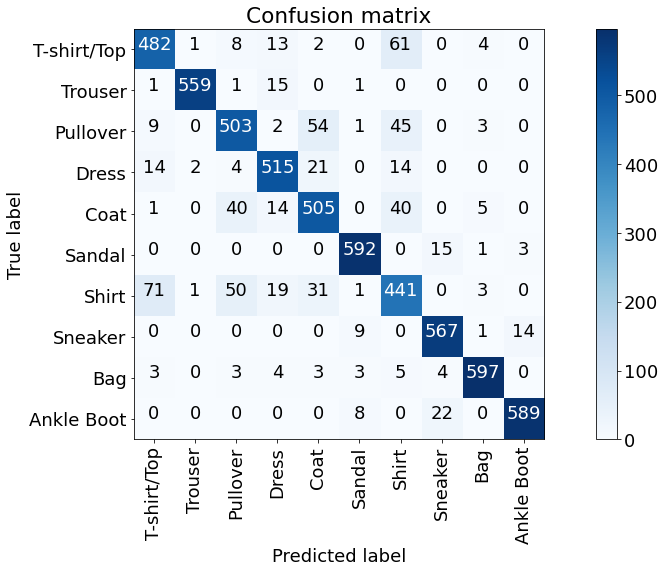

In [12]:
# Predict the values from the validation dataset
Y_pred = relu_model_dropout.predict(x_valid_images)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid_labels,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx,  classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])


classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(classification_report(Y_true, Y_pred_classes, target_names = classes))

# Model 4- MLP NN v4 with Early stopping 

Looking deeper on the above plots we can observe that there are some increases of loss during the epochs. Also for the left tale of the loss plot, there is no a significant change during the epochs. This is something we should avoid using an early stoping strategy. [link text]( https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

In [14]:
# Using SGD
optimizer = SGD(lr=0.01)
epochs = 100

relu_model_es = create_model(
    optimizer=optimizer,
    loss_function='categorical_crossentropy',
    vector_size=256,
    hidden_layers=2,
    hidden_activation='relu',
    output_activation='softmax'
)
relu_model_es.summary() # Print a description of the model.

relu_model_history_es = train_model_es(
    model=relu_model_es,
    train_data=x_train_images,
    train_labels=y_train_labels,
    validation_data=(x_valid_images, y_valid_labels),
    epochs=epochs,
    batch_size= 128# x_train_images.shape[0]
)

relu_model_evaluation_es = relu_model_es.evaluate(x_test_images, y_test_labels, verbose=1)
clean_model(model=relu_model_es)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
422/422 [==============================] - 1s 2ms/step - loss: 1.0937 - accuracy: 0.6643 - val_loss: 0.7680 - val_accuracy: 0.7460
Epoch 2/100
422/422 [==============================] - 1s 2ms/step - loss: 0.6588 - accuracy: 0.7844 - va

Result of Train Loss: 0.31502
Result of Validation Loss: 0.37396
Result of Test Loss: 0.37812
Result of Train accuracy     : 0.88839
Result of Validation accuracy: 0.86167
Result Test accuracy      : 0.86420



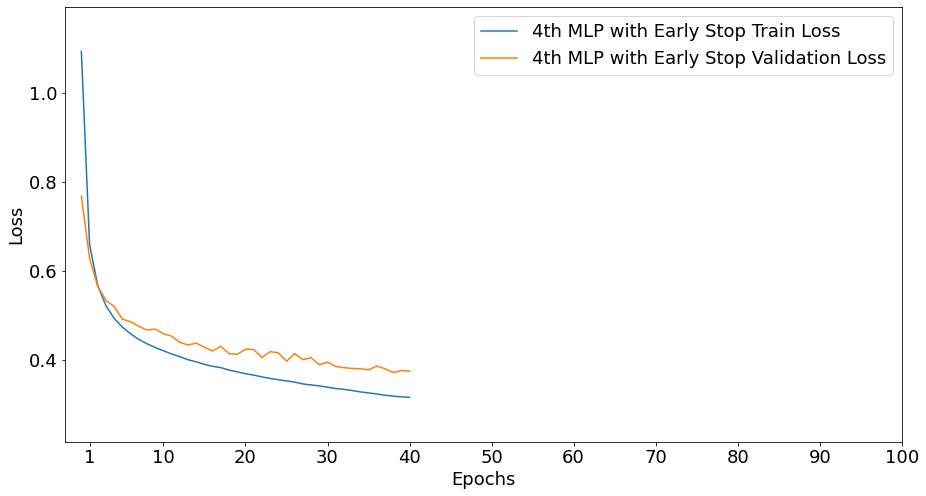

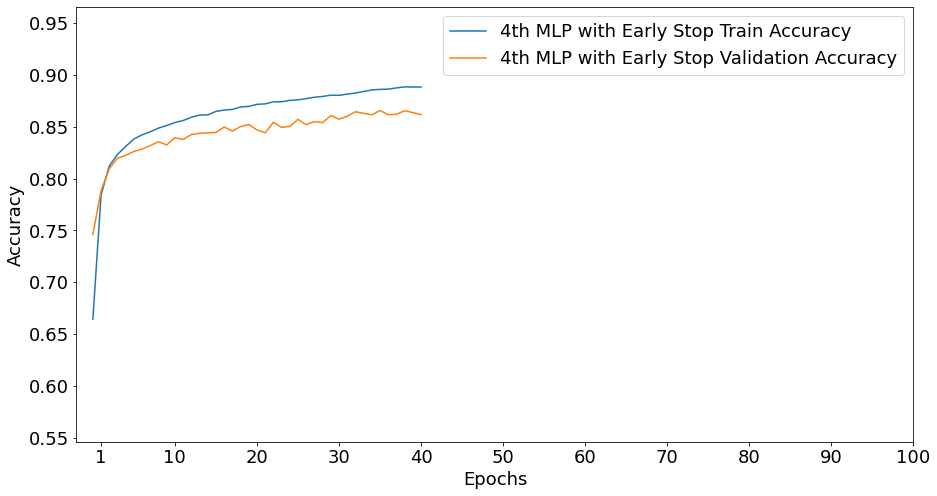

In [15]:
#print loss(train loss, vadlidation loss, and test loss)
print("Result of Train Loss: {0:.5f}".format(relu_model_history_es.history['loss'][-1]))
print("Result of Validation Loss: {0:.5f}".format(relu_model_history_es.history['val_loss'][-1]))
print("Result of Test Loss: {0:.5f}".format(relu_model_evaluation_es[0]))

#print accuracy(train, validation, and test )
print("Result of Train accuracy     : {0:.5f}".format(relu_model_history_es.history['accuracy'][-1]))
print("Result of Validation accuracy: {0:.5f}".format(relu_model_history_es.history['val_accuracy'][-1]))
print("Result Test accuracy      : {0:.5f}".format(relu_model_evaluation_es[1]))

# Plot loss per  epoch
plot = plot_loss(myhistory={'4th MLP with Early Stop': relu_model_history_es}, epochs=epochs, y_low = min(relu_model_history_es.history['loss']) - 0.1, y_high=max(relu_model_history_es.history['loss'])+0.1,loss_function = 'Loss')


# Plot accuracy per epoch
plot = plot_accuracy(myhistory={'4th MLP with Early Stop': relu_model_history_es}, epochs=epochs, y_low = min(relu_model_history_es.history['val_accuracy']) - 0.2, y_high=max(relu_model_history_es.history['val_accuracy']) + 0.1,loss_function = 'Accuracy')

# CNN Models - Data preprocessing

In [13]:
import tensorflow as tf
from tensorflow.keras import datasets, models,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split
from tensorflow.random import set_seed
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout,Conv2D,MaxPooling2D
from tensorflow.keras import backend as K
import itertools
import gc

#load fashion mnist dataset
(x_train_images, y_train_labels), (x_test_images, y_test_labels) = mydataset.load_data()

#split initial train set in final train set and validaton set
x_train_images, x_valid_images, y_train_labels, y_valid_labels = train_test_split(x_train_images, y_train_labels, test_size=0.1)

#reshape and transform data, in order to be accepted in the CNN
x_train_images = x_train_images.reshape(x_train_images.shape[0], 28, 28, 1)
x_test_images = x_test_images.reshape(x_test_images.shape[0], 28, 28, 1)
x_valid_images  = x_valid_images.reshape(x_valid_images.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
x_train_images = x_train_images.astype('float32')
x_test_images = x_test_images.astype('float32')
x_valid_images = x_valid_images.astype('float32')

#normaliation
x_train_images /= 255
x_test_images /= 255
x_valid_images /= 255
y_train_labels = to_categorical(y_train_labels, 10)
y_valid_labels = to_categorical(y_valid_labels, 10)
y_test_labels = to_categorical(y_test_labels, 10)

y_valid_labels.shape



(6000, 10)

# Functions 

In [14]:
#creation of cnn modl 
def create_model_cnn(
    optimizer,
    loss_function,
    filter_dimension,
    conv_layers=0,
    kernel_size=2,
    #activation function uses in convolutional layers
    conv_activation='relu',
    output_activation='softmax',
    #define dropput = 0.4 ( to overcome ovefitting)
    drop_out=0.4
):
    # dimensions = x_train_images[0].shape
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.

    # Model

    #create topology of cnn
    model = Sequential()
    #loop in conv layers
    for i in range(conv_layers):
        div = i + 1
        #add conv layer 
        model.add(Conv2D(filter_dimension * div, 
                         (kernel_size, kernel_size), 
                         activation=conv_activation, 
                         padding='same', #it refers to the amount of pixels added to an image
                         strides=(1, 1), #Stride is the number of pixels shifts over the input matrix
                         dilation_rate=(1, 1), #dilation rate k=1 is normal convolution and k=2 means skipping one pixel per input and k=4 means skipping 3 pixels

                         #glorot uniform is used to initialize weights from a random unform distribution
                         kernel_initializer='glorot_uniform', 
                         input_shape=(28, 28, 1)))
        model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    #Output Layer
     
     #glorot uniform is used to initialize weights from a random unform distribution

    model.add(Dense(10, activation=output_activation,kernel_initializer = 'glorot_uniform')) 
   


    # Compile the model
    model.compile(optimizer=optimizer, loss=loss_function,metrics=['accuracy'])
    return model

#train cnn model 
def train_model(
    model,
    train_data,
    train_labels,
    validation_data,
    epochs=6000,
    batch_size=1024
):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
    # This callback will stop the training when there is no improvement in
    # the validation accuracy for 5 consecutive epochs.

#call model.fit withe appropriate parameters
    hs = model.fit(
        x=train_data,
        y=train_labels,
        validation_data=validation_data,
        callbacks=[callback],
        epochs=epochs,
        verbose=1,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    return hs

# 1st CNN model - Adam optimizer

- Convolutional Layer: 2
- Dropout : 0.2 
- Activation function: Relu
- Loss function: Categorical Crossentropy
- Filter Dimension : 8


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        528       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 8,418
Trainable params: 8,418
Non-trainable params: 0
______________________________________________________

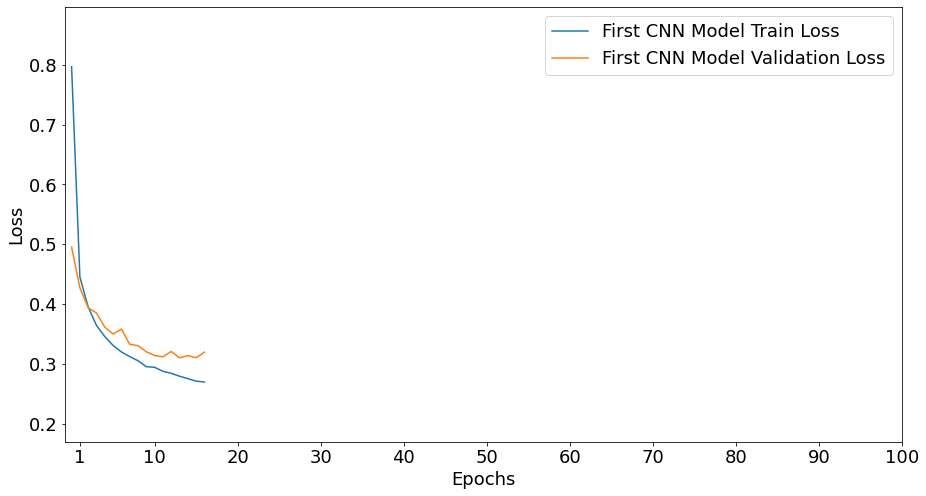

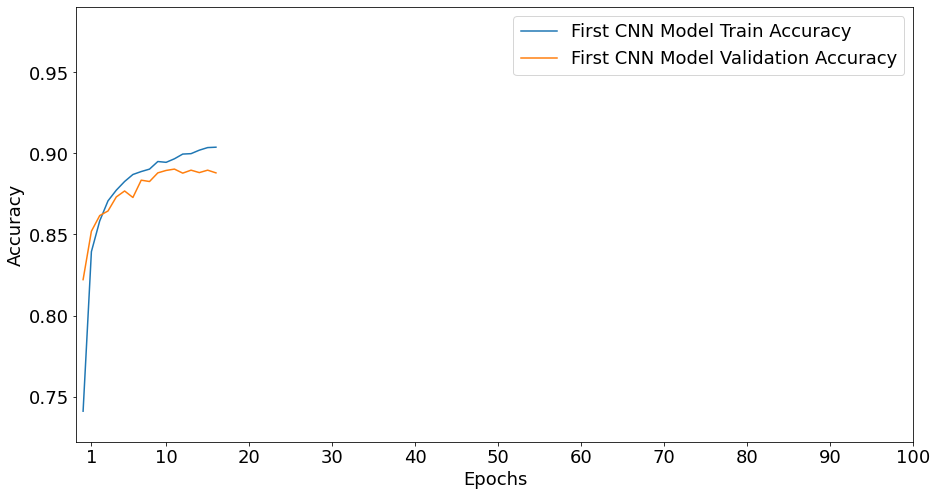

In [18]:
#1st CNN with Adam Optimizer (filter_dimension=8)

#define optimizer
optimizer = Adam()

#define number of epochs 
epochs = 100

#create model
cnn_model_v1= create_model_cnn(
    optimizer=optimizer,
    loss_function='categorical_crossentropy',
    filter_dimension=8,
    #number of conv layers
    conv_layers=2,
    #define kernel size
    kernel_size=2,
    conv_activation='relu',
    output_activation='softmax',
    drop_out=0.2
)

#print model details 
cnn_model_v1.summary()

#train model 
cnn_model_history_v1 = train_model(
    model=cnn_model_v1,
    train_data=x_train_images,
    train_labels=y_train_labels,
    validation_data=(x_valid_images, y_valid_labels),
    epochs=epochs,
    batch_size= 128# x_train_images.shape[0]
)

#evaluate training process
cnn_model_evaluation_v1 = cnn_model_v1.evaluate(x_test_images, y_test_labels, verbose=1)

#clean model
clean_model(model=cnn_model_v1)

#print loss(train loss, validation loss, test losss)
print("Result of Train loss: {0:.5f}".format(cnn_model_history_v1.history['loss'][-1]))
print("Result of Validation loss: {0:.5f}".format(cnn_model_history_v1.history['val_loss'][-1]))
print("Result of Test loss: {0:.5f}".format(cnn_model_evaluation_v1[0]))

#print accuracy(train, validatiom and test)
print("Result of Train accuracy     : {0:.5f}".format(cnn_model_history_v1.history['accuracy'][-1]))
print("Result of Validation accuracy: {0:.5f}".format(cnn_model_history_v1.history['val_accuracy'][-1]))
print("Result of Test accuracy      : {0:.5f}".format(cnn_model_evaluation_v1[1]))

# Plot loss per epoch
plot = plot_loss(myhistory={'First CNN Model': cnn_model_history_v1}, epochs=epochs, y_low = min(cnn_model_history_v1.history['loss']) - 0.1, y_high=max(cnn_model_history_v1.history['loss'])+0.1,loss_function = 'Loss')

#Ploat accuracy per epoch
plot = plot_accuracy(myhistory={'First CNN Model': cnn_model_history_v1}, epochs=epochs, y_low = min(cnn_model_history_v1.history['val_accuracy']) - 0.1, y_high=max(cnn_model_history_v1.history['val_accuracy']) + 0.1,loss_function = 'Accuracy')



# 2nd CNN model - SGD optimizer

- Convolutional Layers: 2
- Drop out : 0.2 
- Activation function: relu 
- Loss function -> categorical cross-entropy
- Optimizer : SGD
- Kernel Size: 2
- Filter Dimension: 8

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        528       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 8,418
Trainable params: 8,418
Non-trainable params: 0
______________________________________________________

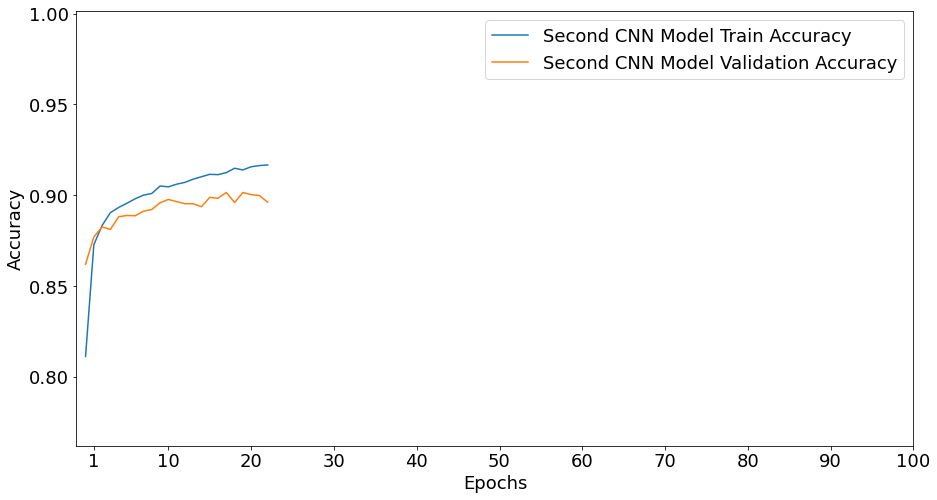

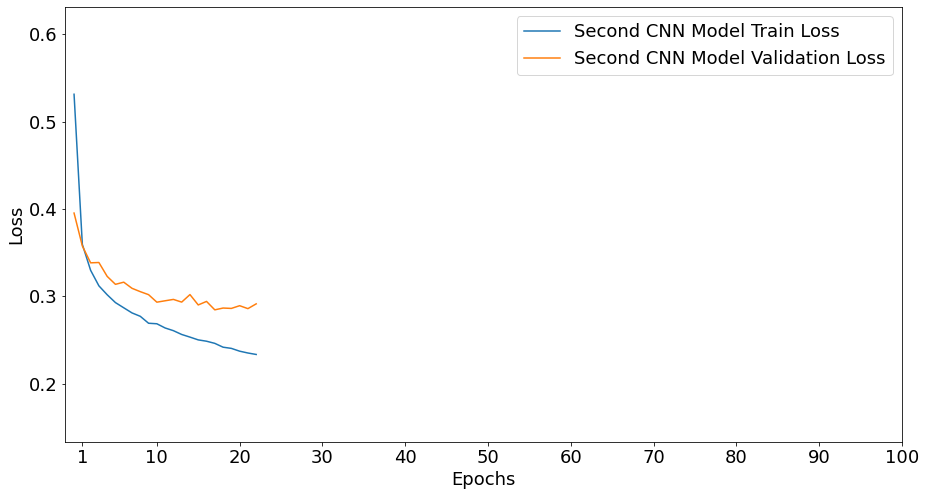

In [19]:
#2nd CNN with SGD Optimizer(filter_dimension=8)

#create the model 
cnn_model_v1_SGD= create_model_cnn(
    optimizer=optimizer,
    loss_function='categorical_crossentropy',
    filter_dimension=8,
    #define number of conv layers
    conv_layers=2,
    kernel_size=2,
    conv_activation='relu',
    output_activation='softmax',
    drop_out=0.2
)
#model details 
cnn_model_v1_SGD.summary() 

#train model 
cnn_model_history_v1_SGD = train_model(
    model=cnn_model_v1_SGD,
    train_data=x_train_images,
    train_labels=y_train_labels,
    validation_data=(x_valid_images, y_valid_labels),
    epochs=epochs,
    batch_size= 128# x_train_images.shape[0]
)

#evaluate train modl
cnn_model_evaluation_v1_SGD = cnn_model_v1_SGD.evaluate(x_test_images, y_test_labels, verbose=1)

#clean the model
clean_model(model=cnn_model_v1_SGD)

#print Validation Loss
#print("Validation loss: {0:.5f}".format(cnn_model_history_v1_SGD.history['val_loss'][-1]))

#print Train Accuracy
#print("Train accuracy     : {0:.5f}".format(cnn_model_history_v1_SGD.history['accuracy'][-1]))

#print Validation accuracy
#print("Validation accuracy: {0:.5f}".format(cnn_model_history_v1_SGD.history['val_accuracy'][-1]))

#print Test accuracy
#print("Test accuracy      : {0:.5f}".format(cnn_model_evaluation_v1_SGD[1]))





#print loss(train loss, validation loss, test losss)
print("Result of Train loss: {0:.5f}".format(cnn_model_history_v1_SGD.history['loss'][-1]))
print("Result of Validation loss: {0:.5f}".format(cnn_model_history_v1_SGD.history['val_loss'][-1]))
print("Result of Test loss: {0:.5f}".format(cnn_model_evaluation_v1_SGD[0]))

#print accuracy(train, validatiom and test)
print("Result of Train accuracy : {0:.5f}".format(cnn_model_history_v1_SGD.history['accuracy'][-1]))
print("Result of Validation accuracy: {0:.5f}".format(cnn_model_history_v1_SGD.history['val_accuracy'][-1]))
print("Result of Test accuracy      : {0:.5f}".format(cnn_model_evaluation_v1_SGD[1]))



# Plot train and validation error per epoch.
plot = plot_accuracy(myhistory={'Second CNN Model': cnn_model_history_v1_SGD}, epochs=epochs, y_low = min(cnn_model_history_v1_SGD.history['val_accuracy']) - 0.1, y_high=max(cnn_model_history_v1_SGD.history['val_accuracy']) + 0.1,loss_function = 'Accuracy')


# Plot loss per epoch
plot = plot_loss(myhistory={'Second CNN Model': cnn_model_history_v1_SGD}, epochs=epochs, y_low = min(cnn_model_history_v1_SGD.history['loss']) - 0.1, y_high=max(cnn_model_history_v1_SGD.history['loss'])+0.1,loss_function = 'Loss')





# 3rd CNN model - Adam Optimizer / Change in filter dimension

- Convolutional Layers: 2
- Drop out : 0.2 
- Activation function: relu 
- Loss function -> categorical cross-entropy
- Optimizer : Adam
- Kernel Size: 2
- Filter Dimension: 32


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                31370     
Total params: 39,786
Trainable params: 39,786
Non-trainable params: 0
____________________________________________________

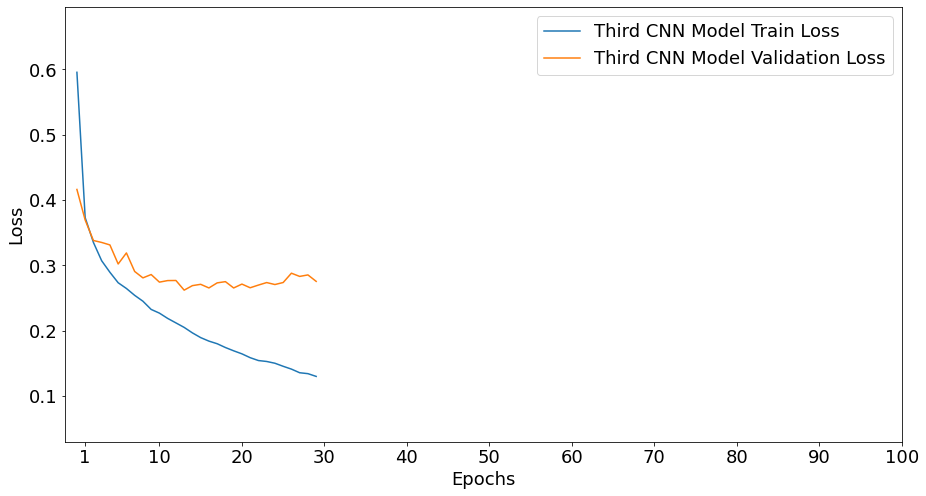

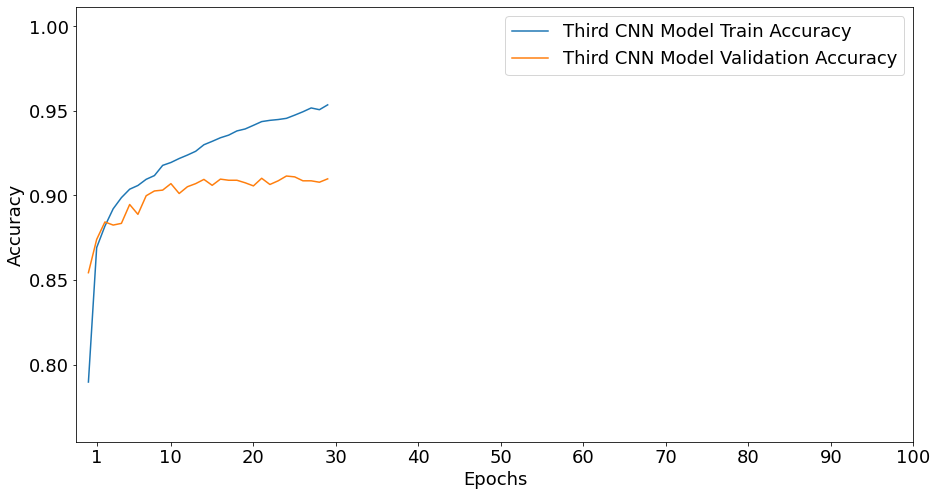

In [15]:
#3rd CNN (Adam Optimizer, filter dimension = 32 , conv layers=2)

optimizer = Adam()
epochs = 100

#create model
cnn_model_v2= create_model_cnn(
    optimizer=optimizer,
    loss_function='categorical_crossentropy',
    #define filter dimension
    filter_dimension=32,
   #define number of conv layers 
    conv_layers=2,
    kernel_size=2,
    conv_activation='relu',
    output_activation='softmax',
    drop_out=0.2
)

#print model details
cnn_model_v2.summary()

#train model 
cnn_model_history_v2 = train_model(
    model=cnn_model_v2,
    train_data=x_train_images,
    train_labels=y_train_labels,
    validation_data=(x_valid_images, y_valid_labels),
    epochs=epochs,
    batch_size= 128# x_train_images.shape[0]
)

#evaluate train model
cnn_model_evaluation_v2 = cnn_model_v2.evaluate(x_test_images, y_test_labels, verbose=1)

#clean model 
clean_model(model=cnn_model_v2)

#print loss(train, validation and test)
print("Train loss: {0:.5f}".format(cnn_model_history_v2.history['loss'][-1]))
print("Validation loss: {0:.5f}".format(cnn_model_history_v2.history['val_loss'][-1]))
print("Test loss: {0:.5f}".format(cnn_model_evaluation_v2[0]))

#print accuracy(train, validation and test )
print("Train accuracy     : {0:.5f}".format(cnn_model_history_v2.history['accuracy'][-1]))
print("Validation accuracy: {0:.5f}".format(cnn_model_history_v2.history['val_accuracy'][-1]))
print("Test accuracy      : {0:.5f}".format(cnn_model_evaluation_v2[1]))


# Plot loss per epoch
plot = plot_loss(myhistory={'Third CNN Model': cnn_model_history_v2}, epochs=epochs, y_low = min(cnn_model_history_v2.history['loss']) - 0.1, y_high=max(cnn_model_history_v2.history['loss'])+0.1,loss_function = 'Loss')

#Ploat accuracy per epoch
plot = plot_accuracy(myhistory={'Third CNN Model': cnn_model_history_v2}, epochs=epochs, y_low = min(cnn_model_history_v2.history['val_accuracy']) - 0.1, y_high=max(cnn_model_history_v2.history['val_accuracy']) + 0.1,loss_function = 'Accuracy')




# Confusion matrix and table

              precision    recall  f1-score   support

 T-shirt/Top       0.85      0.83      0.84       605
     Trouser       0.99      0.98      0.99       613
    Pullover       0.89      0.85      0.87       580
       Dress       0.92      0.92      0.92       617
        Coat       0.86      0.87      0.86       631
      Sandal       0.97      0.99      0.98       568
       Shirt       0.73      0.79      0.76       598
     Sneaker       0.96      0.94      0.95       599
         Bag       0.99      0.97      0.98       586
  Ankle Boot       0.96      0.96      0.96       603

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



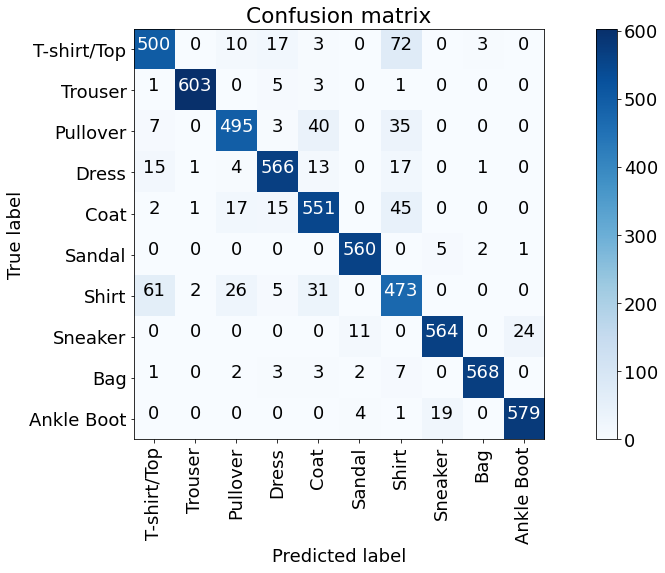

In [16]:
# Predict the values from the validation dataset
Y_pred = cnn_model_v2.predict(x_valid_images)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid_labels,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx,  classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])


classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(classification_report(Y_true, Y_pred_classes, target_names = classes))

# 4nd CNN model - Adam Optimizer Change in Kernel size & Filter dimension

- Convolutional Layers: 2
- Drop out : 0.2 
- Activation function: relu 
- Loss function -> categorical cross-entropy
- Optimizer : Adam
- Kernel Size: 3
- Filter Dimension: 32

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                31370     
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
____________________________________________________

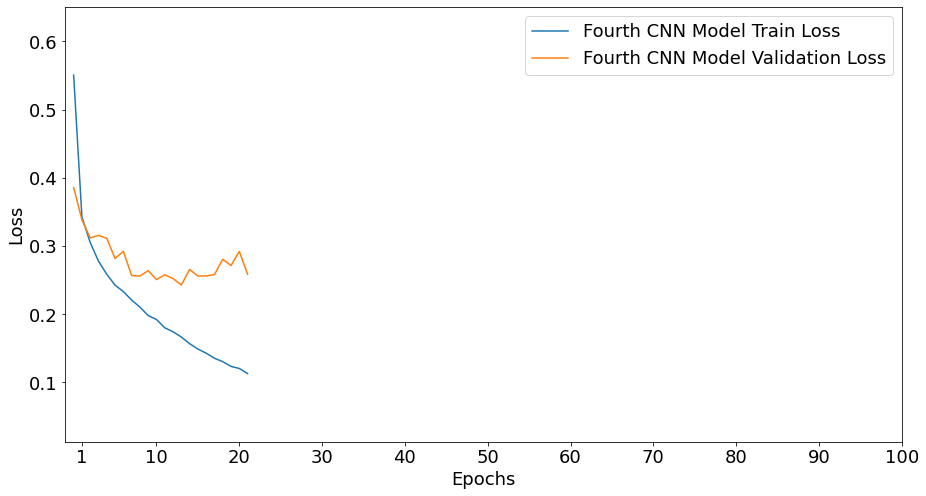

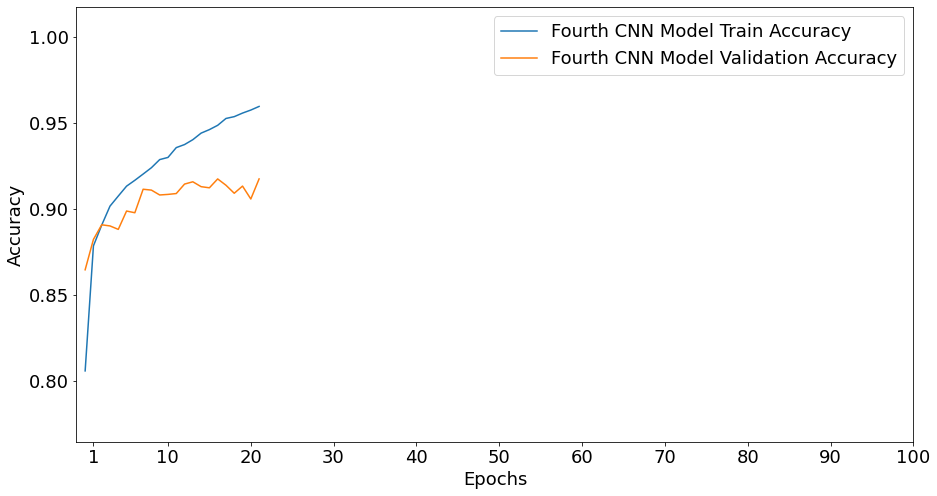

In [21]:
#4th CNN ( kernel size  3x3, optimizer = Adam)

#define optimizer
optimizer = Adam()

#define epochs
epochs = 100

cnn_model_v3= create_model_cnn(
    optimizer=optimizer,
    loss_function='categorical_crossentropy',
    filter_dimension=32,
    conv_layers=2,
    kernel_size=3,
    conv_activation='relu',
    output_activation='softmax',
    drop_out=0.2
)

#print model details
cnn_model_v3.summary() 

#train model
cnn_model_history_v3 = train_model(
    model=cnn_model_v3,
    train_data=x_train_images,
    train_labels=y_train_labels,
    validation_data=(x_valid_images, y_valid_labels),
    epochs=epochs,
    batch_size= 128# x_train_images.shape[0]
)

#evaluate train model
cnn_model_evaluation_v3 = cnn_model_v3.evaluate(x_test_images, y_test_labels, verbose=1)

#clean omdel
clean_model(model=cnn_model_v3)

#print loss(train, validation and test )
print("Train loss: {0:.5f}".format(cnn_model_history_v3.history['loss'][-1]))
print("Validation loss: {0:.5f}".format(cnn_model_history_v3.history['val_loss'][-1]))
print("Test loss: {0:.5f}".format(cnn_model_evaluation_v3[0]))

#print accuracy(train, validation and test )
print("Train accuracy     : {0:.5f}".format(cnn_model_history_v3.history['accuracy'][-1]))
print("Validation accuracy: {0:.5f}".format(cnn_model_history_v3.history['val_accuracy'][-1]))
print("Test accuracy      : {0:.5f}".format(cnn_model_evaluation_v3[1]))

# Plot loss per epoch
plot = plot_loss(myhistory={'Fourth CNN Model': cnn_model_history_v3}, epochs=epochs, y_low = min(cnn_model_history_v3.history['loss']) - 0.1, y_high=max(cnn_model_history_v3.history['loss'])+0.1,loss_function = 'Loss')

#Ploat accuracy per epoch
plot = plot_accuracy(myhistory={'Fourth CNN Model': cnn_model_history_v3}, epochs=epochs, y_low = min(cnn_model_history_v3.history['val_accuracy']) - 0.1, y_high=max(cnn_model_history_v3.history['val_accuracy']) + 0.1,loss_function = 'Accuracy')


